In [1]:
import getpass
import os

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

Enter your Groq API key: ··········


In [2]:
!pip install langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.1 MB/s eta 0:00:00


In [3]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage

In [4]:
llm = ChatGroq(
    model="openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [6]:
llm_with_tools = llm.bind_tools([multiply])

In [7]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 12312322 multiplied by 312321312", name="Lance")])

In [8]:
tool_call

AIMessage(content='', additional_kwargs={'reasoning_content': "We need to multiply 12,312,322 by 312,321,312. That's a large multiplication. We can use the function multiply. The function expects two ints a and b. We'll call it.", 'tool_calls': [{'id': 'fc_5edb69ce-ce6b-4d97-af12-a7dbacbae3b9', 'function': {'arguments': '{"a":12312322,"b":312321312}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 139, 'total_tokens': 213, 'completion_time': 0.074142305, 'prompt_time': 0.009410879, 'queue_time': 0.201919243, 'total_time': 0.083553184}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ddc4d8d5-acfd-42e9-af35-298ba587249f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 12312322, 'b': 312321312}, 'id': 'fc_5edb69ce-ce6b-4d97-af12-a7dbacbae3b9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 13

In [12]:
from langgraph.graph import MessagesState

In [13]:
class MessagesState(MessagesState):
    pass

In [22]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [15]:
def tool_calling_llm(state: MessagesState):
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [23]:
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)
graph = builder.compile()

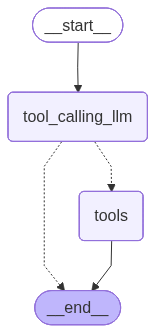

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
messages = [HumanMessage(content="Write a poem about nature?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Write a poem about nature?
================================== Ai Message ==================================

**Whispers of the Wild**

In the hush of dawn, the forest breathes—  
Leaves unfurl like emerald sighs,  
Sunlight drips through branches, a golden weave,  
And rivers hum their ancient lullabies.

Mountains stand, stoic guardians,  
Their peaks kissed by clouds that drift and dance,  
While valleys cradle rivers, swift and clear,  
A living map of earth’s romance.

The wind, a wandering minstrel,  
Sings through grass and stone, a gentle tune,  
It carries scents of pine and rain,  
And whispers secrets of the moon.

Birds, with feathers bright as fire,  
Sketch arcs across the sky,  
Their songs a chorus of pure desire,  
A testament to life’s reply.

Night descends, stars unfurl their glow,  
The moon, a silver lantern, guides the way,  
While crickets play their midnight show,  
And owls in sil

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()